In [1]:
%matplotlib inline


# Training a Classifier

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

## What about data?

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

## Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network **(your main tasks in HA3)**
3. Define a loss function **(your main tasks in HA3)**
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import time

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:05<00:00, 31.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



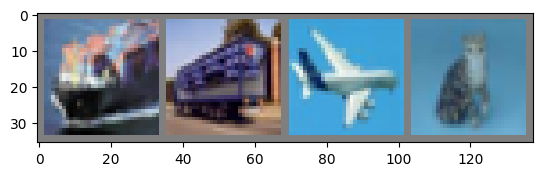

ship                 truck                plane                cat                 


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:20s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network

The below model architecture is the one in the Tutorial 3, you can take it as reference on your own implementation. It is also your baseline to compare with.

In HA3, you need to experiment at least 10 different settings in the ResNet model. Please refer to the HA3 document and try different model archutectures.



In [5]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()

        self.block_1 = torch.nn.Sequential(
                nn.Conv2d(in_channels=3, # Input is 3-channel
                          out_channels=4,
                          kernel_size=(1, 1),
                          stride=(1, 1),
                          padding=0),
                nn.BatchNorm2d(4),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=4,
                          out_channels=1,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.BatchNorm2d(1)
        )

        self.block_2 = torch.nn.Sequential(
                nn.Conv2d(in_channels=3,
                          out_channels=4,
                          kernel_size=(1, 1),
                          stride=(1, 1),
                          padding=0),
                nn.BatchNorm2d(4),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=4,
                          out_channels=1,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.BatchNorm2d(1)
        )

        self.linear_1 = nn.Linear(3*32*32, num_classes)


    def forward(self, x):
        shortcut = x
        x = self.block_1(x)
        x = torch.nn.functional.relu(x + shortcut)

        shortcut = x
        x = self.block_2(x)
        x = torch.nn.functional.relu(x + shortcut)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        logits = self.linear_1(x)
        return logits


model = ConvNet(num_classes=10)

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.

In HA3, besides the model architecture, you also need to try different optimizers and learning rate, as described in HA3.

To adjust learning rate, you can refer to https://pytorch.org/docs/main/optim.html#how-to-adjust-learning-rate.



In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.

In HA3, feel free to change this part of code to get more insights for your report writing.



In [7]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

start_time = time.time()
for epoch in range(2):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(trainloader):

        logits = model(features)
        loss = criterion(logits, targets)
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if not batch_idx % 2500:
            print('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' % (
                epoch+1, 2, batch_idx, len(trainloader), loss
            ))

    model = model.eval() # eval mode to prevent upd. batchnorm params during inference
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
            epoch+1, 2, compute_accuracy(model, trainloader)
        ))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/002 | Batch 000/12500 | Loss: 2.3286
Epoch: 001/002 | Batch 2500/12500 | Loss: 1.6935
Epoch: 001/002 | Batch 5000/12500 | Loss: 1.7441
Epoch: 001/002 | Batch 7500/12500 | Loss: 0.9746
Epoch: 001/002 | Batch 10000/12500 | Loss: 3.4526
Epoch: 001/002 training accuracy: 42.38%
Time elapsed: 1.48 min
Epoch: 002/002 | Batch 000/12500 | Loss: 2.2159
Epoch: 002/002 | Batch 2500/12500 | Loss: 1.9659
Epoch: 002/002 | Batch 5000/12500 | Loss: 1.5841
Epoch: 002/002 | Batch 7500/12500 | Loss: 1.2312
Epoch: 002/002 | Batch 10000/12500 | Loss: 1.5978
Epoch: 002/002 training accuracy: 42.89%
Time elapsed: 2.92 min
Total Training Time: 2.92 min


Let's quickly save our trained model:



In [8]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

In HA3, feel free to change this part of code to get more insights for your report writing.

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



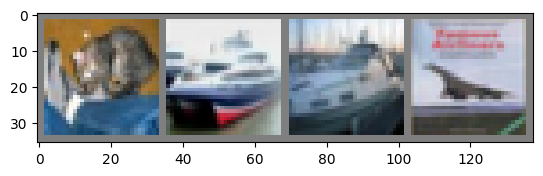

GroundTruth:  cat             ship            ship            plane          


In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:15s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [10]:
model = ConvNet(num_classes=10)
model.load_state_dict(torch.load(PATH))

<ipython-input-10-cb970152aaad>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [11]:
outputs = model(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   truck ship  ship 


Let us look at how the network performs on the whole dataset.



In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 39 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 47.6 %
Accuracy for class: car   is 42.8 %
Accuracy for class: bird  is 28.8 %
Accuracy for class: cat   is 25.3 %
Accuracy for class: deer  is 10.3 %
Accuracy for class: dog   is 29.2 %
Accuracy for class: frog  is 50.6 %
Accuracy for class: horse is 58.6 %
Accuracy for class: ship  is 63.8 %
Accuracy for class: truck is 42.4 %


Okay, so what next?

How do we run these neural networks on the GPU?

## Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:


    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

    inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Training on multiple GPUs
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out `data_parallel_tutorial`.

## Where do I go next?

-  `Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`
-  `Train a face generator using Generative Adversarial Networks`
-  `Train a word-level language model using Recurrent LSTM networks`
-  `More examples`
-  `More tutorials`
-  `Discuss PyTorch on the Forums`
-  `Chat with other users on Slack`




In [16]:
del dataiter